# MLP with Dropout

### Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


### Data Preparation

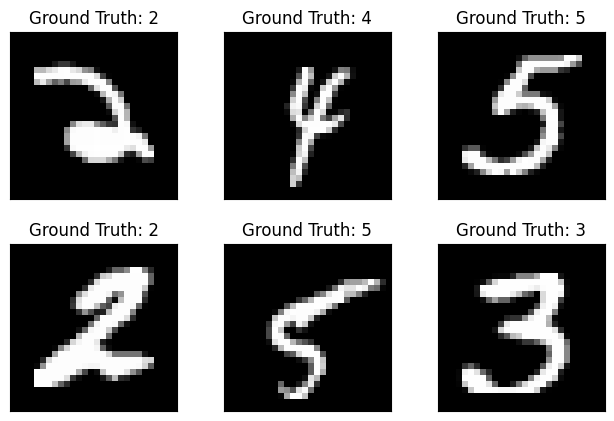

In [6]:
# Define transformations
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5,))])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='/home/tran/Coding/Thesis/DropoutPytorch/data', train=True, transform=transforms, download=True)
test_dataset = datasets.MNIST(root='/home/tran/Coding/Thesis/DropoutPytorch/data', train=False, transform=transforms, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Plot a few examples from the datasets
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

### DBM-like Architecture with Dropout for Finetuning

In [7]:
class DBM(nn.Module):
    def __init__(self):
        super(DBM, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.dropout_input = nn.Dropout(0.8) # Dropout for input layer
        self.fc2 = nn.Linear(500, 500)
        self.dropout_hidden = nn.Dropout(0.5)
        self.fc3 = nn.Linear(500, 2000)
        self.fc4 = nn.Linear(2000, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # Reshape the data
        x = self.dropout_input(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout_hidden(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout_hidden(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout_hidden(x)
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

### Training and Evaluation

In [12]:
def train(model, device, train_loader, optimzer, epoch):
    model.train()
    train_loss = 0
    correct = 0

    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimzer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimzer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


### Training Loop with Tracking and Plotting

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DBM()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/10, Train Loss: 0.0177, Train Accuracy: 60.54%, Test Loss: 0.4307, Test Accuracy: 87.45%
Epoch 2/10, Train Loss: 0.0128, Train Accuracy: 72.77%, Test Loss: 0.3589, Test Accuracy: 89.63%
Epoch 3/10, Train Loss: 0.0118, Train Accuracy: 75.32%, Test Loss: 0.3128, Test Accuracy: 90.71%
Epoch 4/10, Train Loss: 0.0110, Train Accuracy: 76.90%, Test Loss: 0.3179, Test Accuracy: 90.44%
Epoch 5/10, Train Loss: 0.0105, Train Accuracy: 77.99%, Test Loss: 0.2786, Test Accuracy: 92.32%
Epoch 6/10, Train Loss: 0.0102, Train Accuracy: 78.80%, Test Loss: 0.2933, Test Accuracy: 91.31%
Epoch 7/10, Train Loss: 0.0099, Train Accuracy: 79.24%, Test Loss: 0.2538, Test Accuracy: 92.57%
Epoch 8/10, Train Loss: 0.0097, Train Accuracy: 79.80%, Test Loss: 0.2465, Test Accuracy: 92.34%
Epoch 9/10, Train Loss: 0.0096, Train Accuracy: 80.23%, Test Loss: 0.2348, Test Accuracy: 93.31%
Epoch 10/10, Train Loss: 0.0094, Train Accuracy: 80.26%, Test Loss: 0.2266, Test Accuracy: 92.85%


### Plotting Result

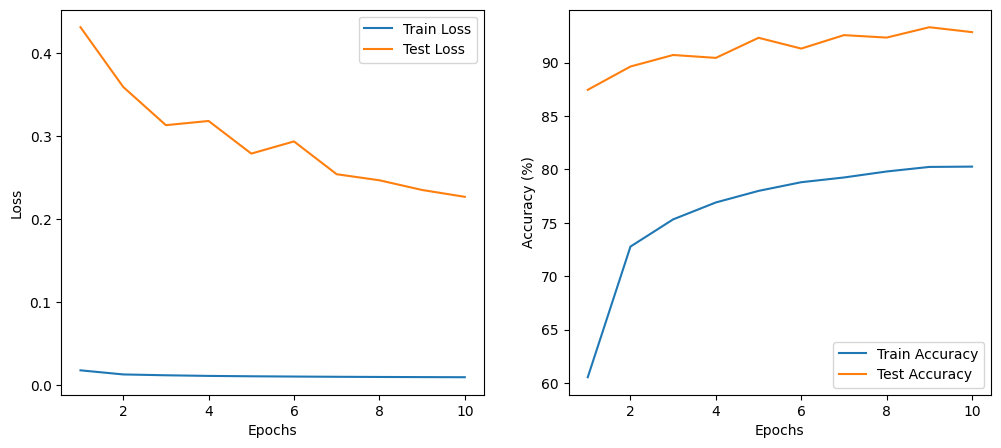

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()